# Machine Learning - Drug Resistance Classification
***
## Introduction
***
A pangenome of 177 *M. tuberculosis* (*Mtb*) strains was filtered down to 85 strains of three different drug resistance classes: <br>

<font color='#00AFBB'>**mono-drug resistant (mono) = class 0**</font> <br>
<font color='#E7B800'>**multi-drug resistant (MDR) = class 1**</font> <br>
<font color='#330099'>**extensively-drug resistant (XDR) = class 2**</font> <br>

Using only the presence/absence of genes in each strain's genome, the following analyses are performed in this notebook:

**Part 1**: With pandas and data visualization packages, genes were identified that could explain differences in drug resistance status. <br>
- For example, are there genes unique to XDR strains that may explain why they are more resistant than mono and MDR strains?

**Part 2**: With TensorFlow and scikit-learn, different machine learning (ML) models were developed to classify drug-resistance status based on the presence/absence of genes. Model accuracies were compared to one another (i.e. benchmarked) to determine which ML model produces the highest accuracy.
- **ML Models: neural network (multilayer perceptron), decision tree, random forest, support vector machine (non-linear, RBF kernel), <br>and logistic regression**

### Resources
**Mtb_pangenome_analysis.xlsx** (used in this notebook): metadata for genomes <br>
**Mtb_pangenome_analysis.py** (not used in this notebook - parses private GBK files): pre-processing script to create .csv <br>
**Mtb_pangenome_analysis.csv** (used in this notebook): gene presence/absence file (binary: 1s/0s) <br>

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import seaborn as sns

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, accuracy_score

from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels-0.11.0rc1-py3.7-macosx-10.9-x86_64.egg/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Part 1: Pangenome Data Analysis
***
### Loads gene presence/absence file for 85 *Mtb* strains and plots drug resistance class counts

DR_status
0.0    21
1.0    12
2.0    52
dtype: int64

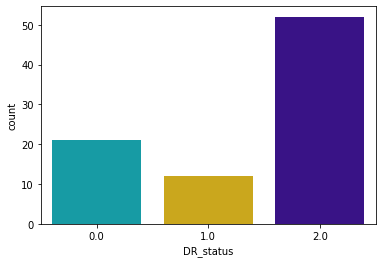

In [2]:
strains = pd.read_csv('../data/Mtb_pangenome_analysis.csv')
strains.set_index('Isolate', inplace=True)

# removes strains without names (not in original dataset) and those with DR_status == 'NA' --> e.g. ND, other, panS
strains.dropna(inplace=True)

sns.countplot(x='DR_status', palette=['#00AFBB', '#E7B800', '#330099'], data=strains)
strains.groupby('DR_status').size()

**Analysis:** There are 85 strains total, however, only 12 of these strains are MDR (1.0). This is likely too small of a sample size to obtain accurate ML results, but we'll roll with it.

### Loads metadata file and plots drug resistance class counts per lineage

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

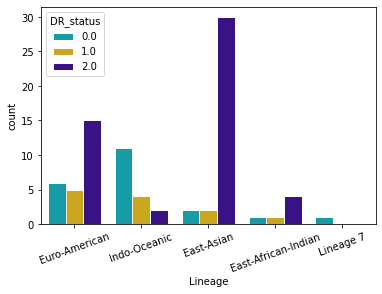

In [3]:
metadata = pd.read_excel('../data/Mtb_pangenome_analysis.xlsx')
metadata.set_index('Isolate', inplace=True)
metadata = metadata.filter(strains.index.values, axis=0).filter(['Number of CDS', 'Lineage'], axis=1)

metadata = strains.join(metadata).filter(['DR_status', 'Number of CDS', 'Lineage'], axis=1).drop('strain_57', axis=0)
# metadata[metadata['Number of CDS'] == 0]  # strain_57: Number of CDS = 0 --> filtered out

sns.countplot(x='Lineage', hue='DR_status', palette=['#00AFBB', '#E7B800', '#330099'], edgecolor='white', data=metadata)
plt.xticks(rotation=20)

**Observation #1:** XDR strains over-represented in Euro-American, **East-Asian**, and East-African Indian lineages <br>
**Observation #2:** mono-resistant strains over-represented in Indo-Oceanic lineage

### Plots coding sequence distribution per drug resistance class

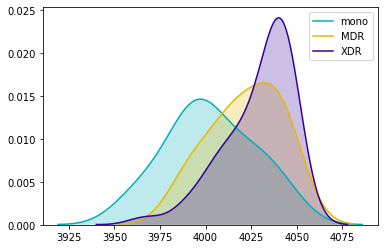

In [4]:
sns.kdeplot(data=metadata.loc[metadata['DR_status'] == 0.0]['Number of CDS'], label='mono', shade=True, color='#00AFBB')
sns.kdeplot(data=metadata.loc[metadata['DR_status'] == 1.0]['Number of CDS'], label='MDR', shade=True, color='#E7B800')
sns.kdeplot(data=metadata.loc[metadata['DR_status'] == 2.0]['Number of CDS'], label='XDR', shade=True, color='#330099')

**Analysis:** XDR strains have more coding sequences on average than MDR and mono-resistant strains. Can some of these additional coding sequences explain the increased resistance of XDR strains?  

### Identifies unique genes in XDR, MDR, and mono-resistant *Mtb* strains

In [5]:
strains_xdr = strains[strains['DR_status'] == 2.0]
strains_xdr = strains_xdr.drop('DR_status', axis=1).T
strains_xdr['sum'] = strains_xdr.sum(axis=1)
genes_xdr = set(strains_xdr[strains_xdr['sum'] != 0].index.to_list())  # removes 47 genes not in any XDR strains

strains_mdr = strains[strains['DR_status'] == 1.0]
strains_mdr = strains_mdr.drop('DR_status', axis=1).T
strains_mdr['sum'] = strains_mdr.sum(axis=1)
genes_mdr = set(strains_xdr[strains_mdr['sum'] != 0].index.to_list())

strains_mono = strains[strains['DR_status'] == 0.0]
strains_mono = strains_mono.drop('DR_status', axis=1).T
strains_mono['sum'] = strains_mono.sum(axis=1)
genes_mono = set(strains_mono[strains_mono['sum'] != 0].index.to_list())

xdr_only = genes_xdr - genes_mdr - genes_mono
mdr_only = genes_mdr - genes_xdr - genes_mono
mono_only = genes_mono - genes_xdr - genes_mdr

print(len(xdr_only), 'unique genes in XDR strains', xdr_only)
print(len(mdr_only), 'unique genes in MDR strains', mdr_only)
print(len(mono_only), 'unique genes in mono-resistant strains', mono_only)

# not_xdr = genes_mdr & genes_mono - genes_xdr  # more IS elements, as expected

6 unique genes in XDR strains {'Rv1370c', 'Rv1763', 'Rv2647', 'Rv1756c', 'Rv0336A', 'Rv1764'}
5 unique genes in MDR strains {'Rv3514', 'Rv2354', 'Rv3185', 'Rv3184', 'Rv3021c'}
2 unique genes in mono-resistant strains {'Rv2561', 'Rv3430a'}


What do these unique genes do?

UniProt functional annotations for genes only in XDR Strains:
- Rv0336A: Conserved 13E12 repeat family protein
- Rv1370c: Insertion element IS6110 uncharacterized 12.0 kDa protein
- Rv1756c: Putative transposase for insertion sequence element IS986/IS6110
- Rv1763: Insertion element IS6110 uncharacterized 12.0 kDa protein
- Rv1764: Putative transposase for insertion sequence element IS986/IS6110
- Rv2647: Uncharacterized protein

*(MDR & mono-resistant strains: unique genes also comprised of IS element genes and uncharacterized genes, as well as PE/PPE genes)* <br>
<br>
**Analysis:** Unfortunately, these gene functions are incapable of explaining how XDR strains may be more drug resistant than MDR and mono-resistant strains. A running hypothesis is that the IS elements in XDR strains are inserting into genes, rendering them non-functional, and confering some drug-resistance benefit. The result of this quick analysis is that XDR strains are only lacking other IS element genes that are unique to the other strains. <br>
**A better analysis would be to compare specific mutations between strains (e.g. variants such as SNPs, indels, structural variants)** (not performed).

### Defines core and accessory genomes across all 85 *Mtb* strains

Core genome:      2302 0.57
Accessory genome: 1714 0.43 



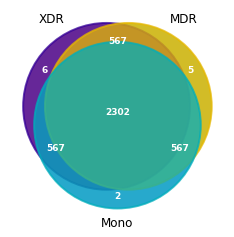

In [6]:
core_accessory = strains[strains.columns.drop('DR_status').to_list()].T
core_accessory['sum'] = core_accessory.sum(axis=1)
# core_accessory['sum'].loc[list(xdr_only)]  # How many XDR strains contain the 6 unique genes? ~ 4 only

genes_core = set(core_accessory[core_accessory['sum'] == core_accessory['sum'].max()].index.to_list())
genes_accessory = set(core_accessory[core_accessory['sum'] != core_accessory['sum'].max()].index.to_list())

print('Core genome:     ', len(genes_core), round(len(genes_core)/core_accessory.shape[0], 2))
print('Accessory genome:', len(genes_accessory), round(len(genes_accessory)/core_accessory.shape[0], 2), '\n')

# note: the counts for doubles (e.g. XDR & MDR = 567) are not correct --> important part is ID'ing unique genes
sub_circles = (len(xdr_only), len(mdr_only), 567, len(mono_only), 567 , 567, len(genes_core))

v = venn3(subsets=sub_circles, set_labels = ('XDR', 'MDR', 'Mono'))
for text in v.subset_labels:
    text.set_color('white')
    text.set_fontsize(9)
    text.set_fontweight('bold')
    
c = venn3_circles(subsets=sub_circles)
c[0].set_color('#330099')
c[0].set_alpha(0.75)
c[1].set_color('#E7B800')
c[1].set_alpha(0.75)
c[2].set_color('#00AFBB')
c[2].set_alpha(0.75)
plt.show()

**Analysis:** There are 2,302 genes (57%) that comprise the core genome (i.e. genes in all strains) and 1,714 genes (43%) that comprise the accessory genome (i.e. genes not in all strains). The unique gene counts for XDR, MDR, and mono-resistant strains reaffirms the previous analysis.   

## Part 2: ML Model Benchmarking
***
### Creates training set for all models

In [7]:
features = strains[strains.columns.drop('DR_status').to_list()]  # features, aka genes
label = strains['DR_status']  # label, aka mono-resistant vs. MDR vs. XDR

X = np.array(features)  # same as features.to_numpy()
y = np.array(label)
y = y.astype('int')

# random_state: allows model comparison --> split by same random state --> test sets will be the exact same
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)

n_features = X_train.shape[1]  # 4,016 features/genes

y_train # good mix of 0s, 1s, 2s

array([0, 0, 2, 0, 0, 1, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 1, 2, 1, 2, 1, 2,
       0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 0, 1, 2, 1, 0, 2, 2, 0, 2,
       1, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0,
       2, 2])

**Training Set: 68/85 *Mtb* strains (80%) & Test Set: 17/85 *Mtb* strains (20%)**

## Part 2a: TensorFlow Neural Networks
***
**Goal: to create models that learn to associate features (genes) with classes/labels (DR_status) <br>
Overall: two models created - with and without Dropout (for overfitting) <br>
Model Type: multilayer perceptron (MLP) - a fully connected neural network, good for tabular data** <br>

*Source #1: https://www.tensorflow.org/tutorials/keras/classification* <br>
*Source #2: https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/*

### Trains and tests MLP model without Dropout layers

In [8]:
model_three_layers = tf.keras.Sequential()

# input_shape: input vector for model (vector of 4,016 features/genes) --> enables layers to create weights
model_three_layers.add(tf.keras.layers.Dense(3000, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model_three_layers.add(tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal'))
# ReLU (rectified linear): if input (summed weights) are positive --> outputs tensor as is (if - --> outputs 0)
# relu + he_normal (weight initialization): overcomes problem of vanishing gradients when training

# 3: one node for each class in output layer --> mono, MDR, XDR // softmax: logits to probs. = easier interpretation
model_three_layers.add(tf.keras.layers.Dense(3, activation='softmax'))

# adam similar to SGD - how model is updated, loss is mesure of training accuracy (best to min) 
model_three_layers.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# applies opt. algorithm to min. loss and updates model using backpropagation of error algorithm (can't viz like reg)
history_model_three_layers = model_three_layers.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_test, y_test))

test_loss, test_acc = model_three_layers.evaluate(X_test, y_test, verbose=2)  # same validation and test dataset
print('Test accuracy:', round(test_acc*100, 0) , '%')  # results vary given stochastic nature of learning algorithm

17/17 - 0s - loss: 1.0980 - accuracy: 0.6471
Test accuracy: 65.0 %


### Plots accuracy curves for MLP model without Dropout layers

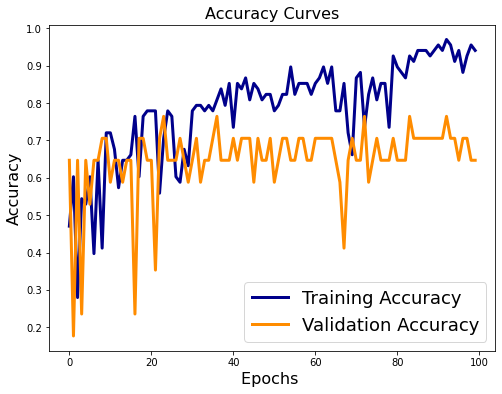

In [9]:
plt.figure(figsize=[8,6])
plt.plot(history_model_three_layers.history['accuracy'],'darkblue',linewidth=3.0)
plt.plot(history_model_three_layers.history['val_accuracy'],'darkorange',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

**Analysis: Model is overfitting training dataset as training accuracy > validation/test accuracy.** <br>
*I think the learning curves reflect this conclusion too since the loss is slightly higher for the validation dataset*

### Plots learning curves for MLP model without Dropout layers

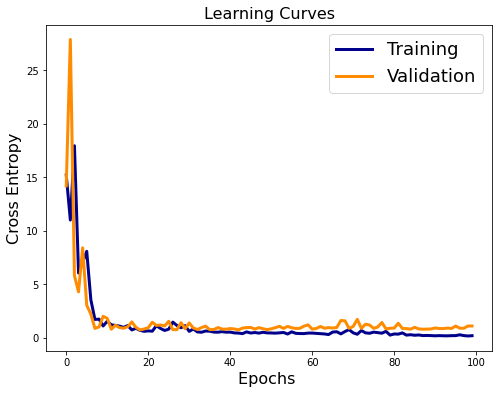

In [10]:
plt.figure(figsize=[8,6])
plt.plot(history_model_three_layers.history['loss'], 'darkblue', linewidth=3.0)
plt.plot(history_model_three_layers.history['val_loss'], 'darkorange', linewidth=3.0)
plt.legend(['Training', 'Validation'],fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Cross Entropy', fontsize=16)
plt.title('Learning Curves', fontsize=16)
plt.show()

### Summarizes MLP model without Dropout layers

In [11]:
model_three_layers.summary()  # Layers 10,8,3 way fewer parameters than Layers 3000, 300, 3  
# tf.keras.utils.plot_model(model_three_layers, 'plots/Mtb_pangenome_analysis_MLP_model.png', show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3000)              12051000  
_________________________________________________________________
dense_1 (Dense)              (None, 300)               900300    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 903       
Total params: 12,952,203
Trainable params: 12,952,203
Non-trainable params: 0
_________________________________________________________________


### Adds Dropout layers to MLP model to reduce overfitting, then trains and tests

In [20]:
model_dropout = tf.keras.Sequential()
model_dropout.add(tf.keras.layers.Dense(3000, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model_dropout.add(tf.keras.layers.Dropout(0.2))  # tried 0.1 & 0.5 (x% of inputs randomly dropped for next layer) 
model_dropout.add(tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal'))
model_dropout.add(tf.keras.layers.Dropout(0.2)) 
model_dropout.add(tf.keras.layers.Dense(3, activation='softmax'))

model_dropout.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_model_dropout = model_dropout.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_test, y_test))

test_loss, test_acc = model_dropout.evaluate(X_test, y_test, verbose=2)  # same validation and test dataset
print('Test accuracy:', round(test_acc*100, 0) , '%')

17/17 - 0s - loss: 0.8177 - accuracy: 0.7647
Test accuracy: 76.0 %


### Plots accuracy curves for MLP model with Dropout layers

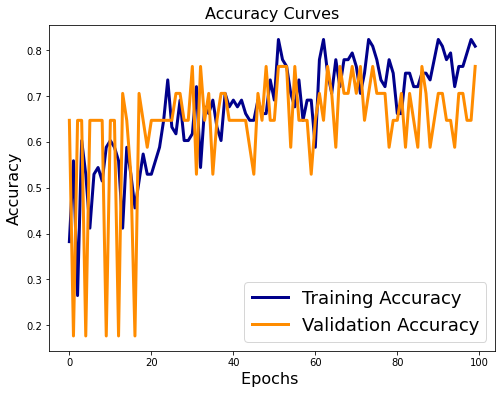

In [21]:
plt.figure(figsize=[8,6])
plt.plot(history_model_dropout.history['accuracy'],'darkblue',linewidth=3.0)
plt.plot(history_model_dropout.history['val_accuracy'],'darkorange',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

**Analysis: There is less ovefitting in the MLP model with Dropouts. As a result, model accuracy improves from 65% to 76% when making predictions with the test dataset.**
- **Potential Next Step:** Early Stopping, i.e. as soon as loss for the validation set starts to show signs of overfitting, stop the training process to avoid overfitting (from tensorflow.keras.callbacks import EarlyStopping --> EarlyStopping(monitor='val_loss', patience=5)

## Plots MLP dropout model predictions
<font color='darkgreen'>Correct Prediction</font> vs. <font color='red'>Incorrect Prediction</font>

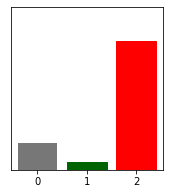

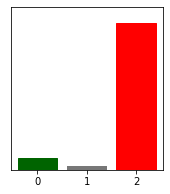

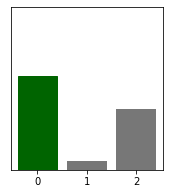

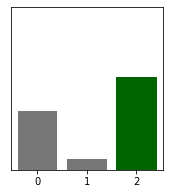

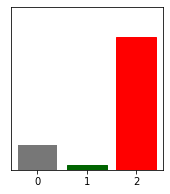

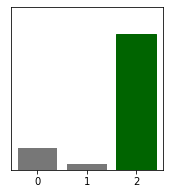

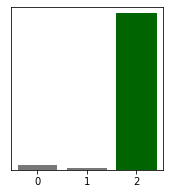

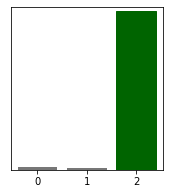

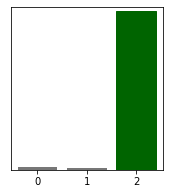

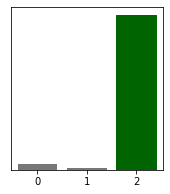

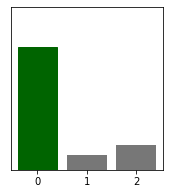

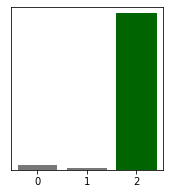

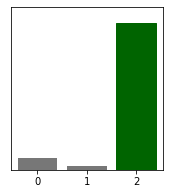

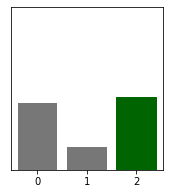

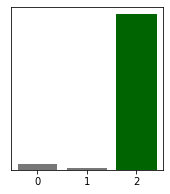

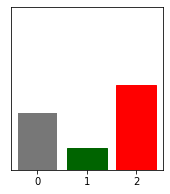

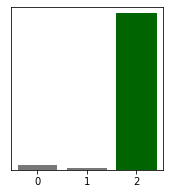

In [22]:
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(3), predictions_array, color='#777777')
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('darkgreen')

predictions = model_dropout.predict(X_test)

for i in range(0, len(y_test), 1):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,2)
    plot_value_array(i, predictions[i], y_test)
    plt.show()

<font color='darkgreen'>**Analysis: 13/17 correct predictions = 76% accuracy**</font>

**Final word on nerual networks:** <br>
Many tweaks were made to certain parameters to improve model performance that were not captured in this notebook. This was intentionally done to enhance clarity of the final workflow. Here are a few examples:
- i) **train_test_split(test_size)**: When this was increased to 0.33 (from 0.2), model accuracy decreased.
- ii) **tf.keras.layers.Dense(3 layers: 10,8,3)**: When nodes (# of parameters) were decreased, model accuracy decreased.
- iii) **tf.keras.layers.Dense(6 layers: 2k,1k,100,10,8,3)**: When number of layers increased, model accuracy decreased.
- iv) **tf.keras.layers.Dense(activation='sigmoid')**: When activation function changed to sigmoid, model accuracy decreased.
- v) **model.fit(epochs=200)**: When iterations thru training dataset increased, model accuracy did not improve.

## Part 2b: Decision Tree  & Random Forest Classifiers
***
### Decision Tree: gini impurity, prediction, accuracy, dot file

In [15]:
clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2)  # one tree only
# default for splitting is Gini impurity - lower is better, weighted based on sample size

clf = clf.fit(X_train, y_train)  # 'training' model w/ training data, for trees: based on Gini impurity

y_pred = clf.predict(X_test)
        
yes_count, no_count = 0, 0
yes = sum([yes_count + 1 for real, pred in zip(y_train, y_pred) if real == pred])
no = sum([no_count + 1 for real, pred in zip(y_train, y_pred) if real != pred])

gini = 1-(yes/(yes+no))**2  # 1 - probability of yes^2 - probability of no^2
print('Gini Impurity: ', round(gini * 100, 0), '%')  # 0 impurity = 100% accuracy

# re-running this code block yields different results due to the high variance present in the algorihtm
print("Decision Tree Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 0), '%')  # or clf.score(X_test, y_test)

export_graphviz(clf, out_file='plots/Mtb_pangenome_analysis_tree.dot', feature_names = features.columns.values.tolist(),
                class_names = ['mono', 'MDR', 'XDR'], rounded = True, proportion = False, precision = 2, filled = True)

# Command Line: $ dot -Tpng Mtb_pangenome_analysis_tree.dot -o Mtb_pangenome_analysis_tree.png -Gdpi=600

Gini Impurity:  78.0 %
Decision Tree Accuracy: 71.0 %


### Random Forest: gini impurity, prediction, accuracy, dot file
Since a random forest creates many decision trees based on sub-samples of the training dataset, it should be more accurate than a single decision tree (and exhibit less variance and overfitting, hopefully). <br>
- I'll probably need to create 1000+ trees since I have over 4016 features --> many or all features/genes included
- reduces variance by: i) training on different samples, ii) by using a random subset of features

In [16]:
clf_rf = RandomForestClassifier(n_estimators=10000, criterion='gini', max_depth=None, min_samples_split=2)
# n_estimators=10,000 for 10,000 trees --> no improvement but reduces variance

clf_rf = clf_rf.fit(X_train, y_train)

y_pred_rf = clf_rf.predict(X_test)

yes_count, no_count = 0, 0
yes_rf = sum([yes_count + 1 for real, pred in zip(y_train, y_pred_rf) if real == pred])
no_rf = sum([no_count + 1 for real, pred in zip(y_train, y_pred_rf) if real != pred])

gini_rf = 1-(yes_rf/(yes_rf+no_rf))**2  # 1 - probability of yes^2 - probability of no^2
print('Gini Impurity: ', round(gini_rf * 100, 0), '%')  # 0 impurity = 100% accuracy

print("Random Forest Accuracy:", round(accuracy_score(y_test, y_pred_rf) * 100, 0), '%')

# # creates decision tree image for one tree only
clf_tree = clf_rf.estimators_[-1]

export_graphviz(clf_tree, out_file='plots/Mtb_pangenome_analysis_forest.dot', feature_names = features.columns.values.tolist(),
                class_names = ['mono', 'MDR', 'XDR'], rounded = True, proportion = False, precision = 2, filled = True)

# Command Line: $ dot -Tpng Mtb_pangenome_analysis_forest.dot -o Mtb_pangenome_analysis_forest.png -Gdpi=600

Gini Impurity:  78.0 %
Random Forest Accuracy: 76.0 %


**Random forest has less variance and is more accurate than the lone decision tree.**<br>
- Also, inspecting the decision tree images, there are no similar genes that match between trees. This isn't too surprising considering we are comparing 1,000 trees from the random forest to the lone decision tree.

## Part 2c: Support Vector Machine Classifiers
***
### Non-linear SVM - Poly kernel: predictions, precision, recall, & confusion matrix
*No Decision Boundary Plot: With 4,016 features/genes, I'm not sure which 2 features to choose to create it.*

SVM_Poly Accuracy:  71.0 %
SVM_Poly Precision: 75.0 %
SVM_Poly Recall:    71.0 %


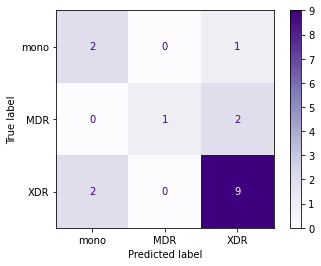

In [17]:
clf_svm_poly = svm.SVC(C=1.0, kernel='poly')
clf_svm_poly.fit(X_train, y_train)

prediction_svm_poly = clf_svm_poly.predict(X_test)
print("SVM_Poly Accuracy: ", round(accuracy_score(y_test, prediction_svm_poly) * 100, 0), '%')

# Model Precision: TP / (TP + FP) --> How many classified positives are actually positive
precision_svm_poly = precision_score(y_test, prediction_svm_poly, labels=[0, 1, 2], average='weighted', zero_division=1)
print("SVM_Poly Precision:", round(precision_svm_poly * 100, 0), '%')

# Model Recall (Sensitivity): TP / (TP + FN) --> How many positive cases correctly classified
recall_svm_poly = recall_score(y_test, prediction_svm_poly, labels=[0, 1, 2], average='weighted', zero_division=1)
print("SVM_Poly Recall:   ", round(recall_svm_poly * 100, 0), '%')

plot_confusion_matrix(clf_svm_poly, X_test, y_test, display_labels=['mono', 'MDR', 'XDR'], cmap=plt.cm.Purples, normalize=None)
plt.show()

### Non-linear SVM - RBF kernel: predictions, precision, recall, & confusion matrix
*Source: https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/*

[2 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2] 

SVM_RBF Accuracy:  76.0 %
SVM_RBF Precision: 83.0 %
SVM_RBF Recall:    76.0 %


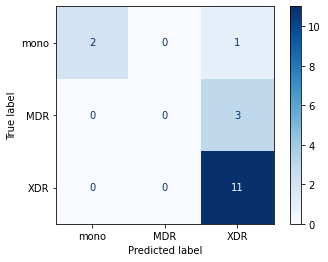

In [18]:
clf_svm_rbf = svm.SVC(C=1.0, kernel='rbf')
clf_svm_rbf.fit(X_train, y_train)

confidence_svm_rbf = clf_svm_rbf.score(X_test, y_test)  # test data now

prediction_svm_rbf = clf_svm_rbf.predict(X_test)
print(prediction_svm_rbf, '\n')

print("SVM_RBF Accuracy: ", round(accuracy_score(y_test, prediction_svm_rbf) * 100, 0), '%')

precision_svm_rbf = precision_score(y_test, prediction_svm_rbf, labels=[0, 1, 2], average='weighted', zero_division=1)
print("SVM_RBF Precision:", round(precision_svm_rbf * 100, 0), '%')

recall_svm_rbf = recall_score(y_test, prediction_svm_rbf, labels=[0, 1, 2], average='weighted', zero_division=1)
print("SVM_RBF Recall:   ", round(recall_svm_rbf * 100, 0), '%')


# print(confusion_matrix(y_test, prediction_svm_rbf))
plot_confusion_matrix(clf_svm_rbf, X_test, y_test, display_labels=['mono', 'MDR', 'XDR'], cmap=plt.cm.Blues, normalize=None)
plt.show()

**Analysis:** non-linear SVM (RBF kernel) only predicts mono-resistant (0) or XDR (2), not MDR (1) <br>
- Algorithms such as the Perceptron, Logistic Regression, and Support Vector Machines were designed for binary classification and do not natively support classification tasks with more than two classes
- One approach for using binary classification algorithms for multi-classification problems is to split the multi-class classification dataset into multiple binary classification datasets and fit a binary classification model on each.
- **One work-around is to use Logistic Regression with a One vs. Rest strategy, which basically splits a multi-class classification problem into multiple binary comparisons, so...**

### Logistic Regression Classifier

In [19]:
# multi_class: multi > binary; argmax of scores (class index with largest score) is used to predict a class
clf_logreg_multi = LogisticRegression(multi_class='ovr', max_iter=10000)
clf_logreg_multi.fit(X_train, y_train)

prediction_logreg_multi = clf_logreg_multi.predict(X_test)
print(prediction_logreg_multi)

print("LogReg_One_vs_Rest Accuracy: ", round(accuracy_score(y_test, prediction_logreg_multi) * 100, 0), '%')

[2 2 0 0 2 2 2 2 2 2 0 2 2 0 2 2 2]
LogReg_One_vs_Rest Accuracy:  65.0 %


## Conclusion
***

| Machine Learning Model | Accuracy | Rank
| --- | --- | --- |
| MLP Neural Network (3 layers + 2 dropouts) | 76% | 1st-t
| Random Forest (10,000 trees) | 76% | 1st-t
| SVM (rbf kernel) | 76% | 1st-t
| Decision Tree | 71% | 4th-t
| SVM (poly kernel) | 71% | 4th-t
| MLP Neural Network (3 layers) | 65% | 6th-t
| Logistic Regression | 65% | 6th-t

**Almost ironically, it's a toss-up between all model types. <br>
The MLP neural network with dropout, random forest classifier, and SVM (RBF kernel) classifier tied for first with an accuracy of 76%. <br>
With more data (and more parameter testing), it's likely a clear-cut winner would emerge.**

### Limitations & Improvements
**i) Small sample size for drug-susceptible (DS) strains: Only 4 DS strains were present in the pangenome, which isn't enough for classification.** <br>
- I could have obtained public genomes from NCBI, ReSeqTB, EMBL-EBI, and PATRIC. However, this would require much more work as I'd have to map differently-labeled locus tags to Rv numbers, probably by sequence similarity/BLASTn, and I'd have to obtain a corresponding drug-resistance status for each genome.)

**ii) Limited number of genomes: 85 total genomes is a small sample size for ML, especially due to the splitting of training and testing data.** <br>
<br>
**iii) Gene presence/absence as features: A more extensive and accurate way to predict drug-resistance status for *Mtb* strains is to use variants (i.e. SNPs, indels, and structural variants) as features.** <br>
- I could have run variant calling software on the genomes. However, even with a list of variants, I would have to come up with a standardized method to create features, i.e. using a combination of known drug-resistance variants, common variants (e.g. variants in 10+ strains), and rare variants (e.g. variants in < 10 strains).